In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Convolution2D, Lambda, Activation, MaxPooling2D, Cropping2D
from keras.layers.advanced_activations import ELU
from keras.preprocessing.image import ImageDataGenerator 
from keras.optimizers import SGD
from keras.layers import Input
import os

Using TensorFlow backend.


In [2]:
data_dirname = "data"
csv = "driving_log.csv"
driving_log = pd.read_csv(os.path.join(data_dirname, csv))

In [3]:
driving_log.head()
driving_log.keys()

Index(['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], dtype='object')

In [4]:
n_train = len(driving_log)
print("Number of training examples =", n_train)

Number of training examples = 8036


In [5]:
central_images = driving_log["center"]
steering_angles = driving_log["steering"]
central_images.head()

0    IMG/center_2016_12_01_13_30_48_287.jpg
1    IMG/center_2016_12_01_13_30_48_404.jpg
2    IMG/center_2016_12_01_13_31_12_937.jpg
3    IMG/center_2016_12_01_13_31_13_037.jpg
4    IMG/center_2016_12_01_13_31_13_177.jpg
Name: center, dtype: object

In [6]:
X_train =[]
y_train = []

for index, image_path in enumerate(central_images):
    f = os.path.join(data_dirname, image_path)
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    steering = steering_angles[index]
    X_train.append(img)
    y_train.append(steering)
    
    rimg = cv2.flip(img, 1)
    r_steering = steering * -1
    X_train.append(rimg)
    y_train.append(r_steering)

X_train = np.array(X_train)
y_train = np.array(y_train)

Steering angle: 0.2116669
Image dimensions: (160, 320, 3)
Number of training examples: (16072,)


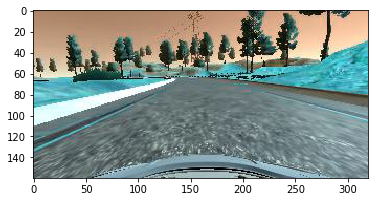

In [7]:
index = random.randint(0, n_train)
image = X_train[index].squeeze()
image_dims = image.shape
output_dims = y_train.shape

plt.imshow(image)
print("Steering angle: {}".format(y_train[index]))
print("Image dimensions: {}".format(image_dims))
print("Number of training examples: {}".format(output_dims))

In [8]:
X_train, y_train = shuffle(X_train, y_train)

#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

In [9]:
def inception_model(image_dims):
    input_tensor = Input(shape=image_dims)
    base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(1)(x)
    model = Model(input=base_model.input, output=predictions)
    model.compile(optimizer="adam", loss="mse")
    
    return model     

In [10]:
def resize(image):
    import tensorflow as tf
    return tf.image.resize_images(image, (64, 32))

def grayscale(image):
    import tensorflow as tf
    return tf.image.rgb_to_grayscale(image)

def normalize(image):
    '''Normalize the image to be between -0.5 and 0.5'''
    return image / 255.0 - 0.5

def base_model(image_dims):
    ch, row, col = image_dims 
    model = Sequential()
    model.add(Lambda(resize, input_shape=(ch, row, col)))
    model.add(Lambda(grayscale))
    model.add(Lambda(normalize))    
    return model 

def comma_ai_model(image_dims):
    
    model = base_model(image_dims)
    
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))    
    model.add(ELU())
    
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    
    model.add(Dense(1))  
    model.compile(optimizer="adam", loss="mse")
    
    return model

def nvidia_model(image_dims):
    model = base_model(image_dims)
    
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid'))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))        
    model.add(Dense(1))        
    model.compile(optimizer="adam", loss="mse")
    
    return model

def simple_model(image_dims):
    model = base_model(image_dims)
    
    model.add(Convolution2D(32, 3, 3))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('relu'))
    model.add(Dense(1))        
    model.compile(optimizer="adam", loss="mse")
    
    return model

In [11]:
model = simple_model(image_dims)

In [12]:
batch_size = 50
nb_epoch = 5

model.fit(X_train, y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_split=0.1)

Train on 14464 samples, validate on 1608 samples
Epoch 1/5
14464/14464 [==============================] - 63s - loss: 0.0140 - val_loss: 0.0116

In [13]:
model.save_weights("model.h5")
print('saving weights')

# Save model config (architecture)
json_string = model.to_json()
with open("model.json", "w") as f:
    f.write(json_string)

print('saving model')

saving weights
saving model
